# O's and X's

Run the source code:

In [237]:
%run "code\ox.py"

## Example 6.1

Demonstration of the perfect player. The function `suggest_move(pq=,player=)` takes a board `pq` and a `player` in $\left\{0,1\right\}$ and returns an integer from 0 to 8 indicating the position to be played.

Two perfect players will always produce a draw.

In [310]:
scores, illegals = play_match(suggest_move, suggest_move, bestof=1000)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}')

Draws: 1000, 
Wins: 0, 
Losses: 0


Here is an example of a board that ends in a draw. Ignoring rotations and reflections, there are only two unique games that occur between two perfect players; one with a horizontal/vertical symmetry and one with a diagonal symmetry.

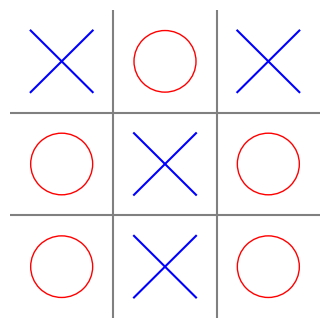

In [311]:
pq, winner, illegal = play_game(suggest_move, suggest_move)
show_board(pq=pq)

Versus a player that selects moves randomly from the available positions, we can see that the perfect player should win almost 100% of the time.

In [308]:
scores, illegals = play_match(suggest_move, random_move, bestof=1000)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}')

Draws: 18, 
Wins: 982, 
Losses: 0


## Example 6.2

The example below trains a model with 2 dense layers of size `p` and `q`. The training parameters `r`, `epochs`, and `batch_size` can be modified. Training takes approximately 1 minute per 500 epochs. There is an early stopping criteria with a patience of 20 epochs.

To assess whether the learning rate and number of epochs is set appropriately for the size of the network, a plot of the loss over time is shown. If the loss still appears to be decreasing when the training reaches the last epoch, it may be that we need to increase the number of epochs or increase the learning rate. If the loss over time becomes very jagged with lots of increases and decreases in later epochs, this could suggest that the learning rate needs to be reduced or that the batch size needs to be increased, as the model is struggling to find steps in the given step direction that reduce the loss.

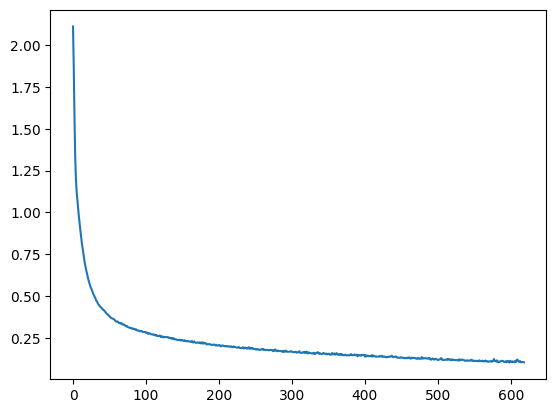

In [233]:
p = 20
q = 20
r = 0.002
epochs = 1000
batch_size = 64

M = make_simple_model(p=p, q=q, r=r)
hist = train_model_suggestions(M=M, epochs=epochs, batch_size=batch_size)
plt.plot(hist.history['loss'])
plt.show()

We can now check the performance of the model by testing it in multiple games against the perfect player. The number of matches can be adjusted to better assess performance, although the code is slower than expected and takes around 20 seconds per 100 games. As well as draws, wins, and losses, we monitor the number of losses due to playing illegal moves.

In [312]:
no_games = 100

def test_model_move(pq, player=0, argmax=False):
    return model_move(M=M, pq=pq, player=0, argmax=False)

scores, illegals = play_match(test_model_move, suggest_move, bestof=no_games)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}, \nLosses due to illegal moves: {illegals[0]}')

Draws: 97, 
Wins: 0, 
Losses: 3, 
Losses due to illegal moves: 3


We can also use a function to switch the activation on the output layer to argmax rather than softmax, giving us the best possible performance for the chosen network architecture and training.

In [313]:
def test_model_move_argmax(pq, player=0, argmax=True):
    return model_move(M=M, pq=pq, player=0, argmax=True)

scores, illegals = play_match(test_model_move_argmax, suggest_move, bestof=no_games)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}, \nLosses due to illegal moves: {illegals[0]}')

Draws: 100, 
Wins: 0, 
Losses: 0, 
Losses due to illegal moves: 0


Finally we can test the argmax model against a random player to see if it also wins almost 100% of the time.

In [314]:
scores, illegals = play_match(test_model_move_argmax, random_move, bestof=no_games)
print(f'Draws: {scores[0]}, \nWins: {scores[1]}, \nLosses: {scores[2]}, \nLosses due to illegal moves: {illegals[0]}')

Draws: 22, 
Wins: 77, 
Losses: 1, 
Losses due to illegal moves: 0


## Example 3.3

This example creates an exact model in one dimension as in example 3.1. We also create another model which is trained using the exact model to see how closely it can replicate the output.

The initial model uses the same input parameters as in example 3.1. For the training, we set `r` to be the learning rate, `samples` to be the number of training samples we generate using the exact model, and `epochs` is the number of epochs for training.

The trained model is usually able to match the exact model on at least one interval, and loosely approximate the shape on the rest. Also, since the trained model uses the same architecture as the exact model, we can see that the trained model also produces a piecewise linear function.

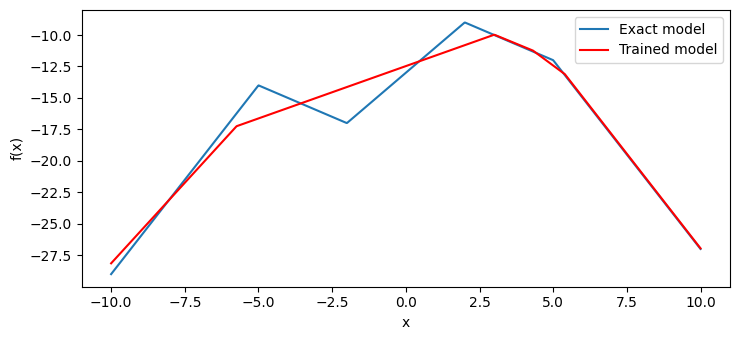

In [36]:
# Specify a in R^r, m in R^R+1, and c in R
a = [-5,-2,2,5]
m = [3,-1,2,-1,-3]
c = 1

# Specify r small (~0.05), samples and epochs large (100+)
r = 0.05
samples=100
epochs=10000

N = make_oned_model(a=np.array(a), m=np.array(m), c=c)
M = make_approx_model(N, r=r)
M = train_approx_model(M=M, N=N, samples=samples, epochs=epochs)
plot_trained_model(M=M, N=N)

Inspecting the weights of each model, we can see that the weights and bias terms in the first layer combine together to determine the locations of the corners as in the exact model. In the case that the trained model is able to match the exact model, the weights and biases of the second layer are adjusted to make the corresponding line segments (possibly in a different order).

In [34]:
print("Trained model")
print("Layer 1:")
[print(np.round(w, 2)) for w in N.layers[1].get_weights()]
print("Layer 2:")
[print(np.round(w, 2)) for w in N.layers[2].get_weights()]
print("Exact model")
print("Layer 1:")
[print(np.round(w, 2)) for w in M.layers[1].get_weights()]
print("Layer 2:")
[print(np.round(w, 2)) for w in M.layers[2].get_weights()]
None

Trained model
Layer 1:
[[ 1. -1.  1.  1.  1.  1.]]
[ 0.  0.  5.  2. -2. -5.]
Layer 2:
[[ 3.]
 [-3.]
 [-4.]
 [ 3.]
 [-3.]
 [-2.]]
[1.]
Exact model
Layer 1:
[[ 0.59 -0.7  -1.04  0.54 -0.02  0.56]]
[-3.12  3.19  3.17  3.17 -0.89  3.27]
Layer 2:
[[-1.92]
 [-1.26]
 [-1.73]
 [-1.33]
 [-0.04]
 [-2.06]]
[7.97]


## Figure code

The following code produce the figures contained in this chapter.

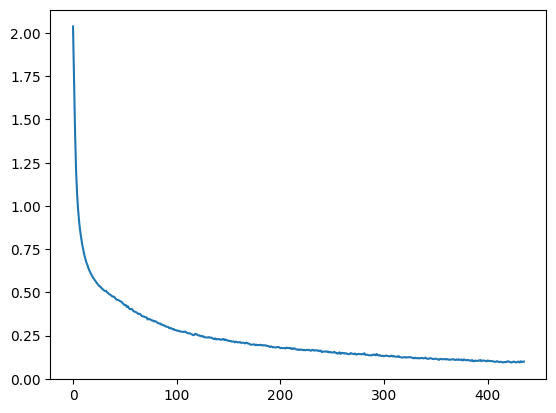

Test model draws: 100, 
Test model wins: 0, 
Test model losses: 0, 
Test model losses due to illegal moves: 0


In [236]:
tf.random.set_seed(210138711)

# Figure 1
M = make_simple_model(p=20, q=20, r=0.002)
hist = train_model_suggestions(M=M, epochs=1000, batch_size=64)

def test_model_move_argmax(pq, player=0, argmax=True):
    return model_move(M=M, pq=pq, player=0, argmax=True)

scores, illegals = play_match(test_model_move_argmax, suggest_move, bestof=no_games)
print(f'Test model draws: {scores[0]}, \nTest model wins: {scores[1]}, \nTest model losses: {scores[2]}, \nTest model losses due to illegal moves: {illegals[0]}')

plt.plot(hist.history['loss'])
plt.show()
